In [45]:
#import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [8]:
# Specify the Mean and standard deviation of all the pixels in the MNIST dataset. They are precomputed 
mean_gray = 0.1307
stddev_gray = 0.3081

#Transform the images to tensors
#Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) 
#for n channels, this transform will normalize each channel of the input torch.Tensor
#i.e. input[channel] = (input[channel] - mean[channel]) / std[channel]

transforms_ori = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean_gray,), (stddev_gray,))])

transforms_photo = transforms.Compose([transforms.Resize((28,28)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((mean_gray,), (stddev_gray,))])

#Load our dataset
train_dataset = datasets.MNIST(root = './data', 
                            train = True, 
                            transform = transforms_ori,
                            download = True)

test_dataset = datasets.MNIST(root = './data', 
                            train = False, 
                            transform = transforms_ori)

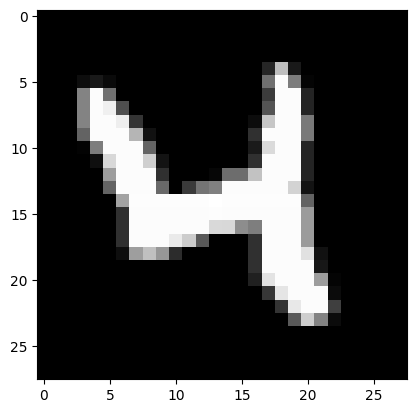

In [17]:
import matplotlib.pyplot as plt
random_image = train_dataset[20][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_image.reshape(28, 28), cmap='gray')

In [18]:
print(train_dataset[20][1])   #Print the corresponding label for the image

4


In [19]:
batch_size = 100
epochs = 10

In [21]:
#Make the dataset iterable
train_load = torch.utils.data.DataLoader(dataset = train_dataset, 
                                         batch_size = batch_size,
                                         shuffle = True)

test_load = torch.utils.data.DataLoader(dataset = test_dataset, 
                                         batch_size = batch_size,
                                         shuffle = False)

In [22]:
print('There are {} images in the training set'.format(len(train_dataset)))
print('There are {} images in the test set'.format(len(test_dataset)))
print('There are {} batches in the train loader'.format(len(train_load)))
print('There are {} batches in the testloader'.format(len(test_load)))

There are 60000 images in the training set
There are 10000 images in the test set
There are 600 batches in the train loader
There are 100 batches in the testloader


In [24]:
#Create the model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        #Same Padding = [(filter size - 1) / 2] (Same Padding--> input size = output size)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3,stride=1, padding=1)
        #The output size of each of the 8 feature maps is 
        #[(input_size - filter_size + 2(padding) / stride) +1] --> [(28-3+2(1)/1)+1] = 28 (padding type is same)
        #Batch normalization
        self.batchnorm1 = nn.BatchNorm2d(8)
        #RELU
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        #After max pooling, the output of each feature map is now 28/2 = 14
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        #Output size of each of the 32 feature maps remains 14
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        #After max pooling, the output of each feature map is 14/2 = 7
        #Flatten the feature maps. You have 32 feature maps, each of them is of size 7x7 --> 32*7*7 = 1568
        self.fc1 = nn.Linear(in_features=1568, out_features=600)
        self.droput = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=600, out_features=10)

        
    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)
        #Now we have to flatten the output. This is where we apply the feed forward neural network as learned before! 
        #It will take the shape (batch_size, 1568) = (100, 1568)
        out = out.view(-1,1568)
        #Then we forward through our fully connected layer 
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc2(out)
        return out

In [26]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [28]:
#Understand what's happening
iteration = 0
correct_nodata = 0
correct_data = 0
for i,(inputs,labels) in enumerate (train_load):
    if iteration==1:
        break
    inputs = Variable(inputs)
    labels = Variable(labels)
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
    print("For one iteration, this is what happens:")
    print("Input Shape:",inputs.shape)
    print("Labels Shape:",labels.shape)
    output = model(inputs)
    print("Outputs Shape",output.shape)
    _, predicted_nodata = torch.max(output, 1)
    print("Predicted Shape",predicted_nodata.shape)
    print("Predicted Tensor:")
    print(predicted_nodata)
    correct_nodata += (predicted_nodata == labels).sum()
    print("Correct Predictions: ",correct_nodata)
    _, predicted_data = torch.max(output.data, 1)
    correct_data += (predicted_data == labels.data).sum()
    print("Correct Predictions:",correct_data)
    

    iteration += 1

For one iteration, this is what happens:
Input Shape: torch.Size([100, 1, 28, 28])
Labels Shape: torch.Size([100])
Outputs Shape torch.Size([100, 10])
Predicted Shape torch.Size([100])
Predicted Tensor:
tensor([9, 0, 9, 4, 9, 5, 9, 4, 5, 3, 9, 4, 5, 9, 8, 9, 9, 5, 4, 9, 9, 5, 5, 9,
        9, 2, 4, 4, 5, 4, 9, 9, 4, 2, 9, 9, 8, 9, 9, 4, 8, 9, 9, 9, 9, 9, 5, 9,
        2, 9, 5, 9, 9, 5, 0, 9, 4, 4, 9, 9, 9, 2, 9, 9, 0, 8, 9, 9, 4, 9, 9, 9,
        8, 4, 8, 6, 6, 9, 5, 0, 8, 5, 9, 9, 7, 9, 9, 5, 4, 9, 9, 9, 9, 9, 9, 9,
        1, 5, 9, 8])
Correct Predictions:  tensor(12)
Correct Predictions: tensor(12)


In [34]:
#Training the CNN
num_epochs = 10

#Define the lists to store the results of loss and accuracy
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

#Training
for epoch in range(num_epochs): 
    #Reset these below variables to 0 at the begining of every epoch
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()                   # Put the network into training mode
    
    for i, (inputs, labels) in enumerate(train_load):
        
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        # If we have GPU, shift the data to GPU
        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()            # Clear off the gradient in (w = w - gradient)
        outputs = model(inputs)         
        loss = loss_fn(outputs, labels)  
        #iter_loss += loss.data[0]       # Accumulate the loss
        iter_loss += loss.item()       # Accumulate the loss
        loss.backward()                 # Backpropagation 
        optimizer.step()                # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))
   

  #*********************************************************

    #Testing
    testing_loss = 0.0
    correct = 0
    iterations = 0

    model.eval() # Put the network into evaluation mode
    
    for i, (inputs, labels) in enumerate(test_load):
        
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)     
        loss = loss_fn(outputs, labels) # Calculate the loss
        #loss += loss.data[0]
        testing_loss += loss.item()
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        
        iterations += 1

    # Record the Testing loss
    test_loss.append(testing_loss/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))
    
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             test_loss[-1], test_accuracy[-1]))

Epoch 1/10, Training Loss: 0.091, Training Accuracy: 97.338, Testing Loss: 0.060, Testing Acc: 98.120
Epoch 2/10, Training Loss: 0.079, Training Accuracy: 97.693, Testing Loss: 0.059, Testing Acc: 98.230
Epoch 3/10, Training Loss: 0.072, Training Accuracy: 97.932, Testing Loss: 0.048, Testing Acc: 98.470
Epoch 4/10, Training Loss: 0.064, Training Accuracy: 98.157, Testing Loss: 0.046, Testing Acc: 98.580
Epoch 5/10, Training Loss: 0.058, Training Accuracy: 98.282, Testing Loss: 0.041, Testing Acc: 98.710
Epoch 6/10, Training Loss: 0.054, Training Accuracy: 98.380, Testing Loss: 0.040, Testing Acc: 98.790
Epoch 7/10, Training Loss: 0.049, Training Accuracy: 98.527, Testing Loss: 0.037, Testing Acc: 98.830
Epoch 8/10, Training Loss: 0.047, Training Accuracy: 98.645, Testing Loss: 0.035, Testing Acc: 98.820
Epoch 9/10, Training Loss: 0.044, Training Accuracy: 98.710, Testing Loss: 0.035, Testing Acc: 98.840
Epoch 10/10, Training Loss: 0.041, Training Accuracy: 98.797, Testing Loss: 0.033,

In [35]:
#Run this if you want to save the model
torch.save(model.state_dict(),'CNN_MNIST.pth')

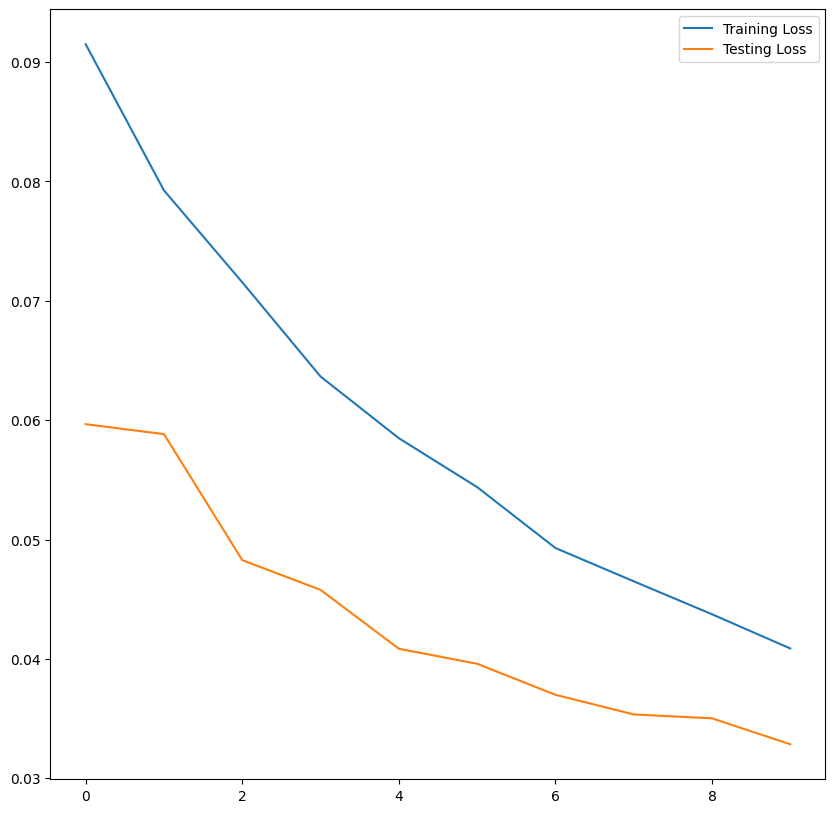

In [36]:
# Loss
f = plt.figure(figsize=(10, 10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

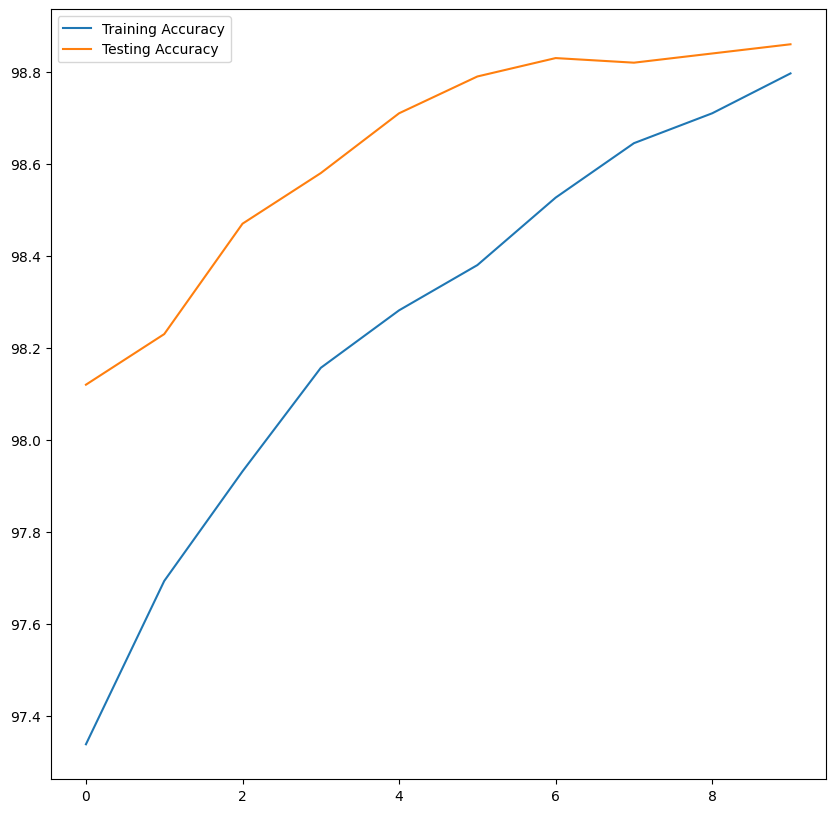

In [37]:
# Accuracy
f = plt.figure(figsize=(10, 10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

In [ ]:
#Run this if you want to load the model
model.load_state_dict(torch.load('CNN_MNIST.pth'))

In [39]:
#Predict your own image
def predict(img_name,model):
    image = cv2.imread(img_name,0)   #Read the image
    ret, thresholded = cv2.threshold(image,127,255,cv2.THRESH_BINARY)   #Threshold the image
    img = 255-thresholded           #Apply image negative
    cv2.imshow('Original',img)      #Display the processed image
    cv2.waitKey(0)              
    cv2.destroyAllWindows()
    img = Image.fromarray(img)      #Convert the image to an array
    img = transforms_photo(img)     #Apply the transformations 
    img = img.view(1,1,28,28)       #Add batch size 
    img = Variable(img)             #Wrap the tensor to a variable
    
    model.eval()

    if torch.cuda.is_available():
        model = model.cuda()
        img = img.cuda()

    output = model(img)
    print(output)
    print(output.data)
    _, predicted = torch.max(output,1)
    return  predicted.item()

In [40]:
pred = predict('3.jpg', model)
print("The Predicted Label is {}".format(pred))

NameError: name 'cv2' is not defined